# View CPT Results for experiment "20112012-all_words-gov_opp"

In [24]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (10, 7)

## Topic word perplexity

In [25]:
import os

def load_perplexity_results(results_dir):
    perplexity_topic = pd.read_csv(os.path.join(results_dir, 'perplexity_topic.csv'), index_col=0)
    perplexity_opinion = pd.read_csv(os.path.join(results_dir, 'perplexity_opinion.csv'), index_col=0)
    
    return perplexity_topic, perplexity_opinion

In [26]:
results_dir = '/home/jvdzwaan/data/dilipad/results/20112012/all_words/'

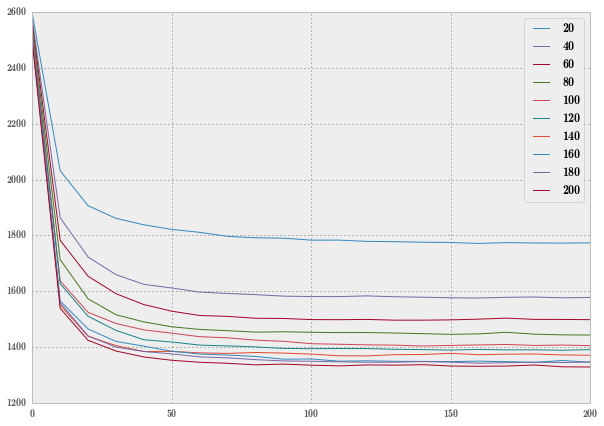

In [27]:
perplexity_topic, perplexity_opinion = load_perplexity_results(results_dir)
perplexity_topic.plot();

In [28]:
# change intervals if needed
intervals = ['20', '100', '180', '200']

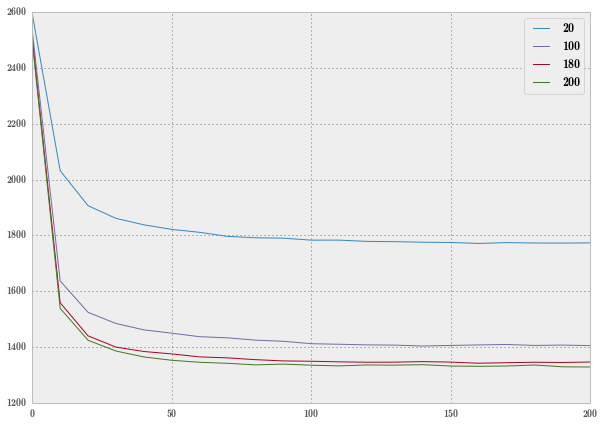

In [29]:
perplexity_topic[intervals].plot();

## Opinion word perplexity

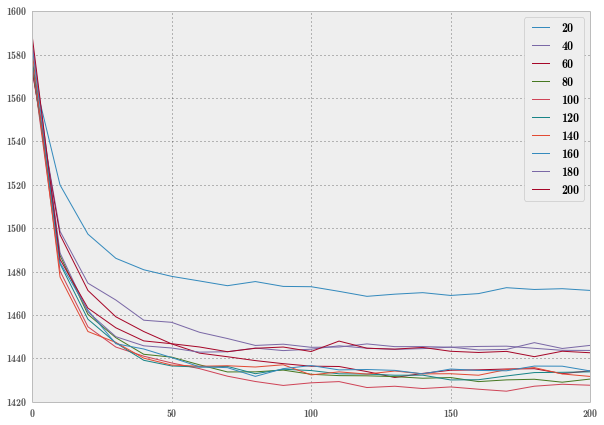

In [30]:
perplexity_opinion.plot();

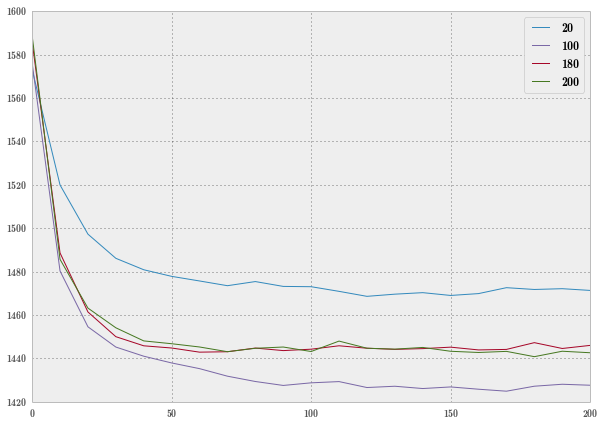

In [31]:
perplexity_opinion[intervals].plot();

## Results for topics and opinions

In [41]:
# choose optimal number of topics based on perplexity results
nTopics = 180

In [42]:
# load results
import glob
import os
import re

def load_experiment_results(nTopics, results_dir):

    # document topic matrix (theta)
    theta = pd.read_csv(os.path.join(results_dir, 'theta_{}.csv'.format(nTopics)), index_col=0)

    # phi topic (transposed)
    phi_topic_t = pd.read_csv(os.path.join(results_dir, 'topics_{}.csv'.format(nTopics)), index_col=0, encoding='utf-8')

    # phi opinion (transposed) per perspective
    opinion_files = glob.glob('{}/opinions_*_{}.csv'.format(results_dir, nTopics))
    phis_opinion_t = {}
    for f in opinion_files:
        m = re.match(r'.+opinions_(.+).csv', f)
        name = m.group(1).replace('_{}'.format(nTopics), '')
        phis_opinion_t[name] = pd.read_csv(f, index_col=0, encoding='utf-8')
    return theta, phi_topic_t, phis_opinion_t

In [43]:
theta, phi_topic_t, phis_opinion_t = load_experiment_results(nTopics, results_dir)

### 'Weight' of the most important topic per document

Each topic has a certain weight in the document. We would like to see one (or a few) topics with high weight per document. Below are some basic statistics on the most important topic (highest weight) per document. 

In [44]:
def print_topic_weights(theta):
    a = theta.copy().apply(max, axis=1)
    a.sort(ascending=False)

    print 'Mean weight of most important topic: {} (std: {})'.format(a.mean(), a.std())
    print 'Min and max of most important topic: min: {}, max: {}'.format(a.min(), a.max())
    print 'Median weight of most important topic: ', a.median()

print_topic_weights(theta)

Mean weight of most important topic: 0.21083112996 (std: 0.16146242126)
Min and max of most important topic: min: 0.00555555555556, max: 0.698626431549
Median weight of most important topic:  0.175600347666


Line graph of the sorted topic weigths:

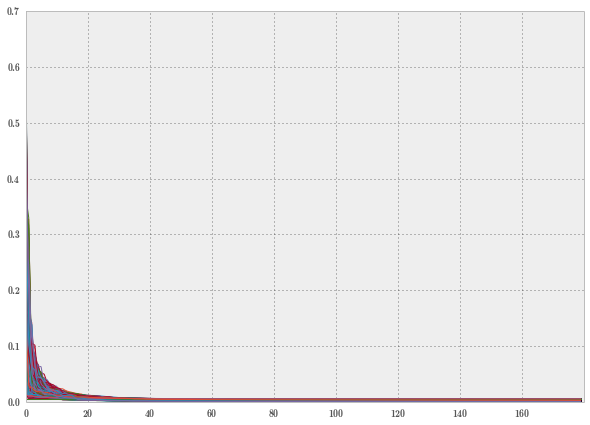

In [45]:
def plot_topic_weights(theta):
    theta.copy().apply(lambda row:sorted(row)[::-1], axis=1).transpose().plot(legend=None);

plot_topic_weights(theta)

### Number of topics per document

The number of topics per document is calculated by counting the number of topic with weight above a certain threshold. The numer of topics per document should (roughly) be equivalent to the number of ``pm:topic``s per document (however, at the moment we do not have statistics of this).

0    264
1    418
2    426
3    242
4     77
5     19
6      5
dtype: int64


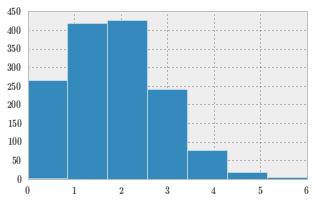

In [46]:
def display_number_of_topics_per_document(theta, threshold=0.05):
    topic_counts = theta.apply(lambda row: np.sum(row > threshold), axis=1)
    print topic_counts.value_counts(sort=False)
    topic_counts.hist(bins=len(topic_counts.value_counts()), figsize=(5,3));

display_number_of_topics_per_document(theta)

### Topics

In [47]:
def show_topic(t, top=10):
    """Return dataframe containing <top> topic words, weights of topic words and per perspective opinion words and
    weigths of opinion words.
    
    Parameters
        t : str - index of topic number
        top : int - the number of words to store in the dataframe
    
    Returns Pandas DataFrame
    """
    topic = phi_topic_t[t].copy()
    topic.sort(ascending=False)
    topic = topic[0:top]
    df_t = pd.DataFrame(topic)
    df_t.reset_index(level=0, inplace=True)
    df_t.columns = ['topic_{}'.format(t), 'weights_topic_{}'.format(t)]

    dfs = [df_t]

    for p, o in phis_opinion_t.iteritems():
        opinion = o[t].copy()
        opinion.sort(ascending=False)
        opinion = opinion[0:top]
        df_o = pd.DataFrame(opinion)
        df_o.reset_index(level=0, inplace=True)
        df_o.columns = ['opinion_{}_{}'.format(t, p), 'weights_opinion_{}_{}'.format(t, p)]
        dfs.append(df_o)
        
    return pd.concat(dfs, axis=1)

def print_topics(phi_topic_t, phis_opinion_t, nTopics):
    jsd = None
    jsdFile = os.path.join(results_dir, 'jsd_{}.csv'.format(nTopics))
    if os.path.isfile(jsdFile):
        print 'Ordering topics by Jensen-Shannon divergence of the opinions'
        print
        jsd = pd.read_csv(jsdFile, index_col=0)
        r = jsd.sort(['jsd'], ascending=False)
        print 'Min jsd: {}, max jsd: {}'.format(np.min(jsd['jsd']), np.max(jsd['jsd']))
        print 'Average jsd: {} (std: {}), median jsd: {}'.format(np.mean(jsd['jsd']), np.std(jsd['jsd']), np.median(jsd['jsd']))
        print
        loop = r.index
    else:
        print 'Ordering topics by topic number'
        print '(To order topics by Jensen-Shannon divergence of the opinions run the experiment_jsd_opinions script.)'
        print
        loop = range(nTopics)
    for i in loop:
        if not jsd is None:
            print 'JSD:', jsd.at[i, 'jsd']
        pLabels = ['opinion_{}_{}'.format(i, p) for p, o in phis_opinion_t.iteritems()]
        print show_topic(str(i))[['topic_{}'.format(i)] + pLabels]
        print

In [48]:
print_topics(phi_topic_t, phis_opinion_t, nTopics)

Ordering topics by Jensen-Shannon divergence of the opinions

Min jsd: 0.135277816657, max jsd: 0.424779414198
Average jsd: 0.346467843662 (std: 0.0383029349684), median jsd: 0.349139583044

JSD: 0.424779414198
        topic_31 opinion_31_Opposition opinion_31_Government
0    vvd-fractie               hiermee              volledig
1    cda-fractie                eerder             overigens
2    pvv-fractie                kennen               daarbij
3         betoog                leggen               daarvan
4      standpunt                  kort               precies
5  gedoogakkoord              proberen               aflopen
6        inbreng               trekken                ingaan
7       rekening               sluiten                eerder
8        kwestie              dezelfde                 delen
9     betrekking              goedkoop                daarop

[10 rows x 3 columns]

JSD: 0.420702439218
              topic_131 opinion_131_Opposition opinion_131_Government
0   